# Defining a target

## Goal
Imagine that we can perfectly predict `a certain` target. Can we come out with a trading strategy based on this model? How often and accurate do our models need to be able to do this?
* This is the quantity that we want to predict: (S1.pct_change()+1).shift(-2) = S1.pct_change().shift(-2)+1
* Its equivalent to predicting S1.pct_change().shift(-2)

In [3]:
cd ~/Desktop/MyProjects/moneyManager/

/Users/lduque/Desktop/myProjects/moneyManager


In [4]:
import pandas as pd
import random
import numpy as np
from datetime import datetime

In [7]:
from modeling.loadTimeSeries import loadTimeSeries
S=loadTimeSeries('GS', datetime(2019,1,1), datetime(2020,1,1)).consolidated

In [23]:
S.reset_index()

,date,consolidated
0,2019-01-02 14:31:00,160.85250
1,2019-01-02 14:32:00,160.76400
2,2019-01-02 14:33:00,161.08350
3,2019-01-02 14:34:00,161.08750
4,2019-01-02 14:35:00,161.04075
...,...,...
97735,2019-12-31 20:56:00,229.75000
97736,2019-12-31 20:57:00,229.67750
97737,2019-12-31 20:58:00,229.54000
97738,2019-12-31 20:59:00,229.51000


In [13]:
S.head()

date
2019-01-02 14:31:00    160.85250
2019-01-02 14:32:00    160.76400
2019-01-02 14:33:00    161.08350
2019-01-02 14:34:00    161.08750
2019-01-02 14:35:00    161.04075
Name: consolidated, dtype: float64

In [10]:
S.index[0]

Timestamp('2019-01-02 14:31:00')

In [14]:
S[datetime(2019,1,2,14,31)]

160.85250000000002

In [17]:
datetime(2019,1,2,14,32) in S

True

In [27]:
minutesPerDay = 390

def simulateMultipleStrategies(S1, S2, precision = 80, recall=10, numExperiments=100, sizeExperiment=1*minutesPerDay):
    """ Comment
    """

    S = pd.concat([S1,S2], axis=1).dropna()
    S.columns=['S1', 'S2']
    lenS=len(S)
    experimentStarts = random.choices(range(lenS-sizeExperiment), k=numExperiments)

    endPriceS1=[]
    endPriceS2= []
    endPriceStragegy = []
    movementsStrategy = []
    
    for es in experimentStarts:
        T1=S[es:es+sizeExperiment]['S1']
        T2=S[es:es+sizeExperiment]['S2']
        end1, end2, endStrategy, numMovements = simulateStrategyWithNoisyPredictor(T1, T2, precision, recall)
        endPriceS1.append(end1)
        endPriceS2.append(end2)
        endPriceStragegy.append(endStrategy)
        movementsStrategy.append(numMovements)
    return endPriceS1, endPriceS2, endPriceStragegy, movementsStrategy


def simulateStrategyWithNoisyPredictor(S1, S2, precision, recall):
    """ Comment
    """
    lenS = len(S1)
    I1 = (1+S1.pct_change()).fillna(1).values
    I2 = (1+S2.pct_change()).fillna(1).values
    SymbolMin = ['S1' if I1[i]<I2[i] else 'S2' for i in range(lenS)]
    SymbolMax = ['S1' if I1[i]>I2[i] else 'S2' for i in range(lenS)]
    
    numPredictions = (lenS*recall)//100
    numCorrectPredictions = (numPredictions*precision)//100
    predictionIndexes = random.sample(range(lenS), numPredictions)
    correctPredictionIndexes = predictionIndexes[:numCorrectPredictions]
    wrongPredictionIndexes = predictionIndexes[numCorrectPredictions:]
        
    SymbolStrategy = [None]*lenS
    for goodIndex in correctPredictionIndexes: SymbolStrategy[goodIndex]=SymbolMax[goodIndex] 
    for badIndex in wrongPredictionIndexes: SymbolStrategy[badIndex]=SymbolMin[badIndex]
    SymbolStrategy[0] = random.choice(['S1','S2']) if  SymbolStrategy[0]==None else SymbolStrategy[0]
    for i in range(1, lenS): SymbolStrategy[i]=SymbolStrategy[i-1] if SymbolStrategy[i]==None else SymbolStrategy[i]    
    Strategy = [I1[i] if SymbolStrategy[i]=='S1' else I2[i] for i in range(lenS)]
    
    numMovements = 0
    for i in range(1,lenS): numMovements+=(1 if SymbolStrategy[i]!=SymbolStrategy[i-1] else 0)    
    return np.prod(I1), np.prod(I2), np.prod(Strategy), numMovements
    

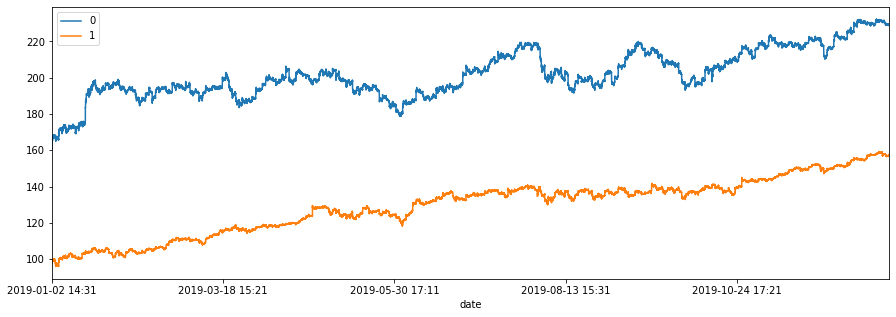

In [28]:
df = pd.read_csv('data/quantopian/minuteIntraday/GS.csv').drop(columns=['volume']).set_index('date')
S1 = df.mean(axis=1)
df = pd.read_csv('data/quantopian/minuteIntraday/MSFT.csv').drop(columns=['volume']).set_index('date')
S2 = df.mean(axis=1)
pd.concat([S1,S2], axis=1).plot(figsize=(15,5))

In [29]:
df

,open_price,high,low,close_price,symbol
date,,,,,
2019-01-02 14:31,98.100,98.149,97.499,97.568,MSFT
2019-01-02 14:32,97.568,97.903,97.508,97.804,MSFT
2019-01-02 14:33,97.824,97.913,97.706,97.775,MSFT
2019-01-02 14:34,97.771,97.942,97.706,97.908,MSFT
2019-01-02 14:35,97.897,98.208,97.893,97.962,MSFT
...,...,...,...,...,...
2019-12-31 20:56,157.610,157.770,157.610,157.705,MSFT
2019-12-31 20:57,157.705,157.740,157.600,157.610,MSFT
2019-12-31 20:58,157.610,157.660,157.570,157.610,MSFT


In [30]:
endStock1, endStock2, endStrategy, movementsStrategy = simulateMultipleStrategies(S1, S2, precision = 70, recall=10, numExperiments=200, sizeExperiment=20*390)

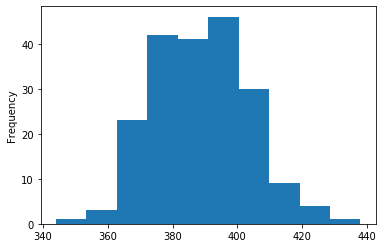

In [31]:
pd.Series(movementsStrategy).plot.hist()

In [32]:
dr=pd.DataFrame({'endStock1':endStock1, 'endStock2':endStock2, 'endStrategy':endStrategy})

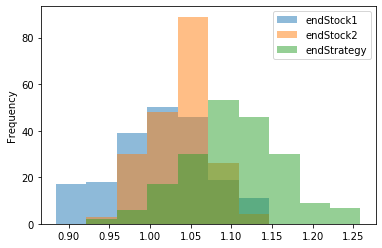

In [33]:
dr.plot.hist(bins=10, alpha=0.5)

In [34]:
dr['bestStock']=dr[['endStock1', 'endStock2']].max(axis=1)

In [35]:
dr['difference']=dr.endStrategy-dr.bestStock

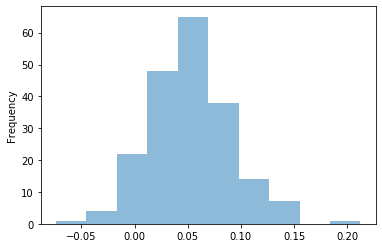

In [36]:
dr.difference.plot.hist(bins=10, alpha=0.5)

In [42]:
dr.difference.describe()

count    200.000000
mean       0.053382
std        0.039084
min       -0.073730
25%        0.027145
50%        0.051429
75%        0.078090
max        0.212266
Name: difference, dtype: float64

date
2019-01-02 14:31     97.499
2019-01-02 14:32     97.508
2019-01-02 14:33     97.706
2019-01-02 14:34     97.706
2019-01-02 14:35     97.893
                     ...   
2019-12-31 20:56    157.610
2019-12-31 20:57    157.600
2019-12-31 20:58    157.570
2019-12-31 20:59    157.560
2019-12-31 21:00    157.460
Name: low, Length: 97740, dtype: float64

In [51]:
datetime(2019,1,1,14,32).to

datetime.datetime(2019, 1, 1, 14, 32)

In [54]:
S.index[0]

'2019-01-02 14:31'